## Example: Build a Home Price Prediction Model
In this example, we will predict the housing price based on factors like house area, bedrooms, furnished status, nearness to the main road, etc. The dataset is small; however, its complexity arises because it has strong multicollinearity. [The dataset was downloaded from Kaggle and is available here](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset?select=Housing.csv).

### Acknowledgement:
* Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.
* Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [3]:
include("Include.jl");

## Prerequisites 
Let's load the data file. We'll load the file and separate the data into the data matrix $\mathbf{X}$ and the output vector $\mathbf{y}$ using [the `loaddatafile(...)` function](src/Files.jl). This function returns the housing data [as a DataFrame instance](https://dataframes.juliadata.org/stable/).

In [5]:
original_data = loaddatafile(joinpath(_PATH_TO_DATA, "Housing-Training-Dataset-Kaggle.csv"))

Row,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
,Int64,Int64,Int64,Int64,Int64,String3,String3,String3,String3,String3,Int64,String3,String15
1,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
2,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
3,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
4,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
5,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
6,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
7,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
8,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
9,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished


Notice that we have several columns (features) that are categorical, i.e., `{furnished | unfurnished | semifurnished}` or `{yes | no`}. We must replace these values with numbers, e.g., `{0 | 1 | 2}`, etc.
* We'll do this transformation (including changing types from a `String` to an `Int`) using [the `transform!(...)` method exported by the DataFrames.jl package](https://dataframes.juliadata.org/stable/lib/functions/#DataFrames.transform!). This is an advanced operation.

In [7]:
treated_dataset = let

    treated_dataset = copy(original_data);    
    transform!(treated_dataset, :mainroad => ByRow( x-> (x=="yes" ? 1 : -1)) => :transformed_mainroad);
    transform!(treated_dataset, :guestroom => ByRow( x-> (x=="yes" ? 1 : -1)) => :transformed_guestroom);
    transform!(treated_dataset, :basement => ByRow( x-> (x=="yes" ? 1 : -1)) => :transformed_basement);
    transform!(treated_dataset, :hotwaterheating => ByRow( x-> (x=="yes" ? 1 : -1)) => :transformed_hotwaterheating);
    transform!(treated_dataset, :airconditioning => ByRow( x-> (x=="yes" ? 1 : -1)) => :transformed_airconditioning);
    transform!(treated_dataset, :prefarea => ByRow( x-> (x=="yes" ? 1 : -1)) => :transformed_prefarea);
    transform!(treated_dataset, :furnishingstatus => ByRow( x-> (x=="unfurnished" ? -1 : (x=="semi-furnished" ? 0 : 1))) => :transformed_furnishingstatus);
    transform!(treated_dataset, :price => ByRow(x -> x/1000000.0) => :transformed_price);
    transform!(treated_dataset, :area => ByRow(x -> x/1000.0) => :transformed_area);

    # remove the original columns
    select!(treated_dataset, Not([:mainroad,:guestroom,:basement,:hotwaterheating,:airconditioning,:prefarea,:furnishingstatus,:price, :area]))
end;
treated_dataset

Row,bedrooms,bathrooms,stories,parking,transformed_mainroad,transformed_guestroom,transformed_basement,transformed_hotwaterheating,transformed_airconditioning,transformed_prefarea,transformed_furnishingstatus,transformed_price,transformed_area
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,4,2,3,2,1,-1,-1,-1,1,1,1,13.3,7.42
2,4,4,4,3,1,-1,-1,-1,1,-1,1,12.25,8.96
3,3,2,2,2,1,-1,1,-1,-1,1,0,12.25,9.96
4,4,2,2,3,1,-1,1,-1,1,1,1,12.215,7.5
5,4,1,2,2,1,1,1,-1,1,-1,1,11.41,7.42
6,3,3,1,2,1,-1,1,-1,1,1,0,10.85,7.5
7,4,3,4,2,1,-1,-1,-1,1,1,0,10.15,8.58
8,5,3,2,0,1,-1,-1,-1,-1,-1,-1,10.15,16.2
9,4,1,2,2,1,1,1,-1,1,1,1,9.87,8.1


Now let's split the data set into the system input matrix $\mathbf{X}$ (independent variables, characteristics of the house) and the output vector $\mathbf{y}$ (dependent variables, the house price).

In [9]:
X = Matrix(treated_dataset[:, Not(:transformed_price)]); # data matrix: select all the columns *except* price
y = Vector(treated_dataset[:,:transformed_price]); # output vector: select all the price column

In [10]:
X

545×12 Matrix{Float64}:
 4.0  2.0  3.0  2.0   1.0  -1.0  -1.0  -1.0   1.0   1.0   1.0   7.42
 4.0  4.0  4.0  3.0   1.0  -1.0  -1.0  -1.0   1.0  -1.0   1.0   8.96
 3.0  2.0  2.0  2.0   1.0  -1.0   1.0  -1.0  -1.0   1.0   0.0   9.96
 4.0  2.0  2.0  3.0   1.0  -1.0   1.0  -1.0   1.0   1.0   1.0   7.5
 4.0  1.0  2.0  2.0   1.0   1.0   1.0  -1.0   1.0  -1.0   1.0   7.42
 3.0  3.0  1.0  2.0   1.0  -1.0   1.0  -1.0   1.0   1.0   0.0   7.5
 4.0  3.0  4.0  2.0   1.0  -1.0  -1.0  -1.0   1.0   1.0   0.0   8.58
 5.0  3.0  2.0  0.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  16.2
 4.0  1.0  2.0  2.0   1.0   1.0   1.0  -1.0   1.0   1.0   1.0   8.1
 3.0  2.0  4.0  1.0   1.0   1.0  -1.0  -1.0   1.0   1.0  -1.0   5.75
 3.0  1.0  2.0  2.0   1.0  -1.0   1.0  -1.0   1.0   1.0   1.0  13.2
 4.0  3.0  2.0  2.0   1.0   1.0   1.0   1.0  -1.0  -1.0   0.0   6.0
 4.0  2.0  2.0  1.0   1.0  -1.0  -1.0  -1.0   1.0   1.0   0.0   6.55
 ⋮                          ⋮                             ⋮    
 3.0  1.0  2.0  0.0  

Finally, let's partition the data into a `training` and `testing` set so that we can determine how well the model can predict unseen data, i.e., how well the model `generalizes`.

In [12]:
fraction = 0.80
(X_train, X_test, y_train, y_test) = partition(X, y; trainfraction = fraction); # this is a *random* split

In [13]:
X_train

437×12 Matrix{Float64}:
 3.0  1.0  2.0  1.0   1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0   6.0
 3.0  1.0  2.0  0.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0   0.0   3.1
 2.0  1.0  1.0  1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   4.04
 3.0  2.0  4.0  1.0   1.0   1.0  -1.0  -1.0   1.0  -1.0   1.0   6.0
 3.0  1.0  2.0  0.0   1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0   7.0
 3.0  1.0  2.0  2.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0   0.0   4.08
 2.0  1.0  1.0  1.0   1.0  -1.0   1.0   1.0  -1.0  -1.0   1.0  13.2
 2.0  1.0  1.0  0.0   1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0   4.35
 3.0  1.0  4.0  0.0   1.0  -1.0  -1.0  -1.0   1.0   1.0  -1.0   5.02
 3.0  1.0  1.0  0.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0   0.0   4.34
 3.0  1.0  3.0  0.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0   0.0   3.51
 3.0  1.0  3.0  2.0   1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0   8.372
 3.0  2.0  2.0  0.0   1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0   3.0
 ⋮                          ⋮                             ⋮    
 2.0  1.0  1.0  1.0 

## Task 1: Expected value of the parameters $\beta$ without regularization
We know that the `data matrix` $\mathbf{X}$ is `overdetermined`, i.e., $m>n$ (more equations than unknowns). Thus, we are solving the minimization problem for an unknown parameter estimates $\hat{\beta}$:
$$
\begin{equation*}
\hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}} ||~\mathbf{y} - \mathbf{X}\cdot\mathbf{\beta}~||^{2}_{2}
\end{equation*}
$$
where $||\star||^{2}_{2}$ is the square of the p = 2 vector norm. Then, the value of the unknown parameter vector $\mathbf{\beta}$ that minimizes the sum of the squares loss function for an overdetermined system is given by:
\begin{equation*}
\hat{\mathbf{\beta}} = \left(\mathbf{X}^{T}\mathbf{X}\right)^{-1}\mathbf{X}^{T}\mathbf{y} - \left(\mathbf{X}^{T}\mathbf{X}\right)^{-1}\mathbf{X}^{T}\mathbf{\epsilon}
\end{equation*}
The matrix $\mathbf{X}^{T}\mathbf{X}$ is called the normal matrix, while $\mathbf{X}^{T}\mathbf{y}$ is called the moment matrix. The __expectation__ removes the error term.

In [15]:
β̂ = inv(transpose(X_train)*X_train)*transpose(X_train)*y_train;
ŷ_train = X_train*β̂;

Let's compute the `ŷ_test` values using `X_test.`. Remember: the model has never seen these values of the data matrix $\mathbf{X}$; thus, this is a pure _out of sample_ prediction:

In [17]:
ŷ_test = X_test*β̂;

### Analysis: Training
First, let's compute an error metric for the training case. Then, we'll plot the data and the model to visualize the model's performance.

* Let's use the [norm function exported by the LinearAlgebra package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm) to compute the `distance` between the observed `y_train` output and calculated output `X_train*β̂` values. We store this in the `δ_train` variable. The larger the `δ_train,` the __worse__ the model is learning the data. Thus, a large value of `δ_train` is bad.

In [19]:
δ_train = let
    N = length(y_train);
    ϵ = (1/N)*(y_train .- ŷ_train)
    δ_train = norm(ϵ)
end

0.054328203771173735

`Unhide` the code block below to see how we plot the computed and observed home prices for a model without regularization for the _training data_.

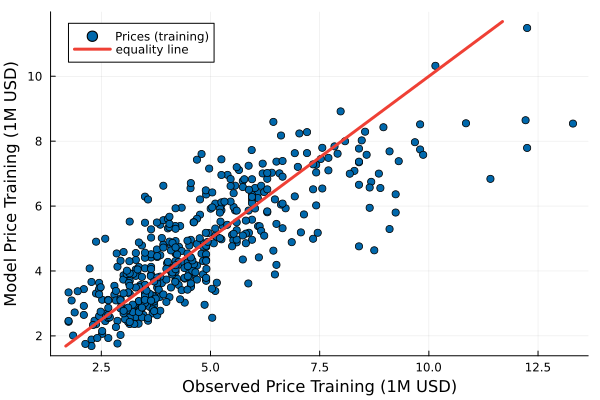

In [21]:
let
    xy_line = min(minimum(ŷ_train), minimum(y_train)):10:max(maximum(y_train),maximum(y_train)) |> collect;
    scatter(y_train,ŷ_train,label="Prices (training)",c=colorant"#0068AC")
    plot!(xy_line,xy_line,lw=3, label="equality line", c=colorant"#EF4035");
    xlabel!("Observed Price Training (1M USD)", fontsize=18)
    ylabel!("Model Price Training (1M USD)", fontsize=18)
end

### Analysis: Testing
Now, let's consider the testing performance. Reminder: The model has never seen this data, so this is an out-of-sample test of its performance.

* Let's use the [norm function exported by the LinearAlgebra package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm) to compute the distance between the observed `y_test` output and predicted output `X_test*β̂` values. We store this in the `δ_test` variable:

In [23]:
δ_test = let
    N = length(y_test);
    ϵ = (1/N)*(y_test .- ŷ_test)
    δ_test = norm(ϵ)
end

0.08687068816607561

`Unhide` the code block below to see how we plot the computed and observed home prices for a model without regularization for the _test data_.

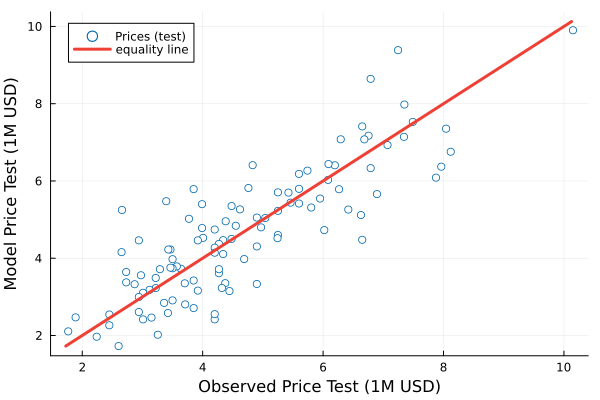

In [25]:
let
    xy_line = min(minimum(y_test), minimum(ŷ_test)):0.1:max(maximum(y_test),maximum(ŷ_test)) |> collect;
    scatter(y_test,ŷ_test,label="Prices (test)", msc=colorant"#0068AC", c=:white)
    plot!(xy_line,xy_line,lw=3, label="equality line", c=colorant"#EF4035");
    xlabel!("Observed Price Test (1M USD)", fontsize=18)
    ylabel!("Model Price Test (1M USD)", fontsize=18)
end

## Task 2: Expected value of the parameters $\beta$ with regularization
In this task, let's see what happens when we add a regularization parameter. If we use `ridge` regularization, i.e., we add a $||\,\beta\,||_{2}^{2}$ term to the objective function:
$$
\begin{equation*}
\hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}} ||~\mathbf{y} - \mathbf{X}\cdot\mathbf{\beta}~||^{2}_{2} + \lambda\cdot{||\,\beta\,||_{2}^{2}}
\end{equation*}
$$

where $\lambda\geq{0}$ is called a `regularization` parameter. This problem has an analytical solution of the form:
\begin{equation*}
\hat{\mathbf{\beta}} = \left(\mathbf{X}^{T}\mathbf{X}+\lambda\cdot\mathbf{I}\right)^{-1}\mathbf{X}^{T}\mathbf{y} - \left(\mathbf{X}^{T}\mathbf{X}+\lambda\cdot\mathbf{I}\right)^{-1}\mathbf{X}^{T}\mathbf{\epsilon}
\end{equation*}
The __expectation__ removes the error term. Let's set a value for the regularization parameter $\lambda\geq{0}$

In [27]:
λ = 100.0;
IM = diagm(ones(12));

Now, solve for the __expected value__ of the unknown parameter vector $\beta$ for the regularized problem. Store the predicted output values from the training data in the `ŷ_train_reg` variable:

In [29]:
β̂_reg = inv(transpose(X_train)*X_train + λ*IM)*transpose(X_train)*y_train;
ŷ_train_reg = X_train*β̂_reg;

Now, let's compute the `ŷ_test_reg` values using `X_test` and the `β̂_reg` parameters. Remember: the model has never seen these values of the data matrix $\mathbf{X}$; thus, this is a pure _out of sample_ prediction:

In [31]:
ŷ_test_reg = X_test*β̂_reg;

### Analysis: Training for regularized model
Let's compute an error metric for the training case when we use regularization. Then, we'll plot the data and the model to visualize the model's performance.
* Let's use the [norm function exported by the LinearAlgebra package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm) to compute the `distance` between the observed `y_train` output and calculated output `X_train*β̂_reg` values. We store this in the `δ_reg_train` variable. The larger the `δ_reg_train,` the __worse__ the model is learning the data. Thus, a large value of $\delta_{\star}$ is bad.

In [33]:
δ_reg_train = let
    N = length(y_train);
    ϵ = (1/N)*(y_train .- ŷ_train_reg)
    δ_reg_train = norm(ϵ)
end

0.055883993721079606

`Unhide` the code block below to see how we plot the observed and simulated home prices for the training data, where the model parameters are estimated using regularization.

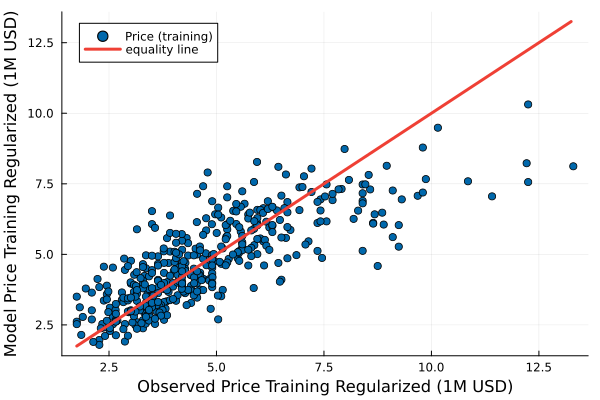

In [35]:
let
    xy_line = min(minimum(y_train), minimum(ŷ_train_reg)):0.1:max(maximum(y_train),maximum(ŷ_train_reg)) |> collect;    
    scatter(y_train,ŷ_train_reg,label="Price (training)",c=colorant"#0068AC")
    plot!(xy_line,xy_line,lw=3, label="equality line", c=colorant"#EF4035");
    xlabel!("Observed Price Training Regularized (1M USD)", fontsize=18)
    ylabel!("Model Price Training Regularized (1M USD)", fontsize=18)
end

### Analysis: Testing for regularized model
Finally, let's look at the error for the regularized testing case. Reminder: The model has never seen this data, so this is an out-of-sample test of its performance.
* Let's use the [norm function exported by the LinearAlgebra package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm) to compute the `distance` between the observed `y_test` output and predicted output `X_test*β̂_reg` values. We store this in the `δ_reg_test` variable. 

In [37]:
δ_reg_test = let
    N = length(y_test);
    ϵ = (1/N)*(y_test .- ŷ_test_reg)
    δ_reg_test = norm(ϵ)
end

0.08534117520014725

`Unhide` the code block below to see how we plot the observed and simulated home prices for the _test data_, where the model parameters are estimated using regularization.

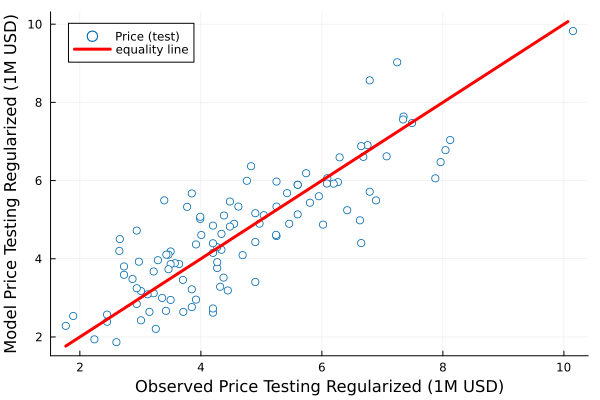

In [39]:
let 
    xy_line = min(minimum(y_test), minimum(ŷ_test_reg)):0.1:max(maximum(y_test),maximum(ŷ_test_reg)) |> collect;    
    scatter(y_test,ŷ_test_reg,label="Price (test)", msc=colorant"#0068AC", c=:white)
    plot!(xy_line,xy_line,lw=3, label="equality line", c=:red);
    xlabel!("Observed Price Testing Regularized (1M USD)", fontsize=18)
    ylabel!("Model Price Testing Regularized (1M USD)", fontsize=18)
end